# Banking Marketing Dataset

In [47]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**Step-1:** Import the dataset

In [48]:
df = pd.read_csv("/kaggle/input/banking-marketing-dataset/data.csv")
df['y'] = df['y'].map({'yes': 1, 'no': 0})     
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,0
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,0
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,1
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,0
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,0


In [49]:
X = df.drop('y', axis=1)
y = df['y']

**Handling the Null values in the dataset**

In [50]:
df.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

In [51]:
print(X.dtypes)

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
dtype: object


In [52]:
# Convert 'object' columns with few unique values to 'category'
for col in X.select_dtypes(include='object').columns:
    if X[col].nunique() < 20:  # adjust threshold based on domain knowledge
        X[col] = X[col].astype('category')

# Fix numeric columns stored as strings (if any)
for col in X.select_dtypes(include='object').columns:
    try:
        X[col] = pd.to_numeric(X[col])
    except ValueError:
        pass  # Keep original if truly non-numeric

**Handling the Outliers**

In [53]:
import pandas as pd

# Identify numerical columns only
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Outlier treatment using IQR method
for col in numeric_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Print number of outliers
    outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")

age: 368 outliers
duration: 2366 outliers
campaign: 1916 outliers
pdays: 1226 outliers
previous: 4534 outliers


In [54]:
X['duration'] = np.log1p(X['duration'])
X['campaign'] = np.log1p(X['campaign'])
X['previous'] = np.log1p(X['previous'])

In [55]:
X['never_contacted'] = (X['pdays'] == -1).astype(int)
X['pdays'] = X['pdays'].clip(lower=0)  # replace -1 with 0 if needed

**Encode the categorical variables**

In [56]:
import pandas as pd

# Identify categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Apply One-Hot Encoding to all categorical columns
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X = X_encoded.copy()

**Constant Feature**

In [57]:
constant_feature = [col for col in X.columns if X[col].nunique == 1]
print(constant_feature)

[]


**Quasi Constant Feature**

In [58]:
quasi_constant_feature = []
threshold = 0.98

for col in X.columns:
    freq = X[col].value_counts(normalize=True).iloc[0]
    if freq >= threshold:
        quasi_constant_feature.append(col)

print("quasi_constant_feature: ", quasi_constant_feature)
print("\nTotal: ", len(quasi_constant_feature))

X = X.drop(columns=quasi_constant_feature, axis=1)

quasi_constant_feature:  ['never_contacted', 'job_unknown', 'marital_unknown', 'education_illiterate', 'default_yes', 'month_dec', 'month_mar', 'month_oct', 'month_sep']

Total:  9


**Duplicate Features**

In [59]:
train_T = X.T
duplicate_features = train_T[train_T.duplicated()].index.tolist()
print(duplicate_features)
print("\nTotal Duplicate Features: ", len(duplicate_features))
X = X.drop(columns=duplicate_features, axis=1)

['loan_unknown']

Total Duplicate Features:  1


**Correlation**

In [60]:
corr_matrix = X.corr()
corr_threshold = 0.98
corr_pairs = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j] > corr_threshold):
            corr_pairs.add(corr_matrix.columns[i])

print("Correlation Features: ",corr_pairs)
print("\nTotal: ", len(corr_pairs))

X = X.drop(columns=corr_pairs, axis=1)

Correlation Features:  set()

Total:  0


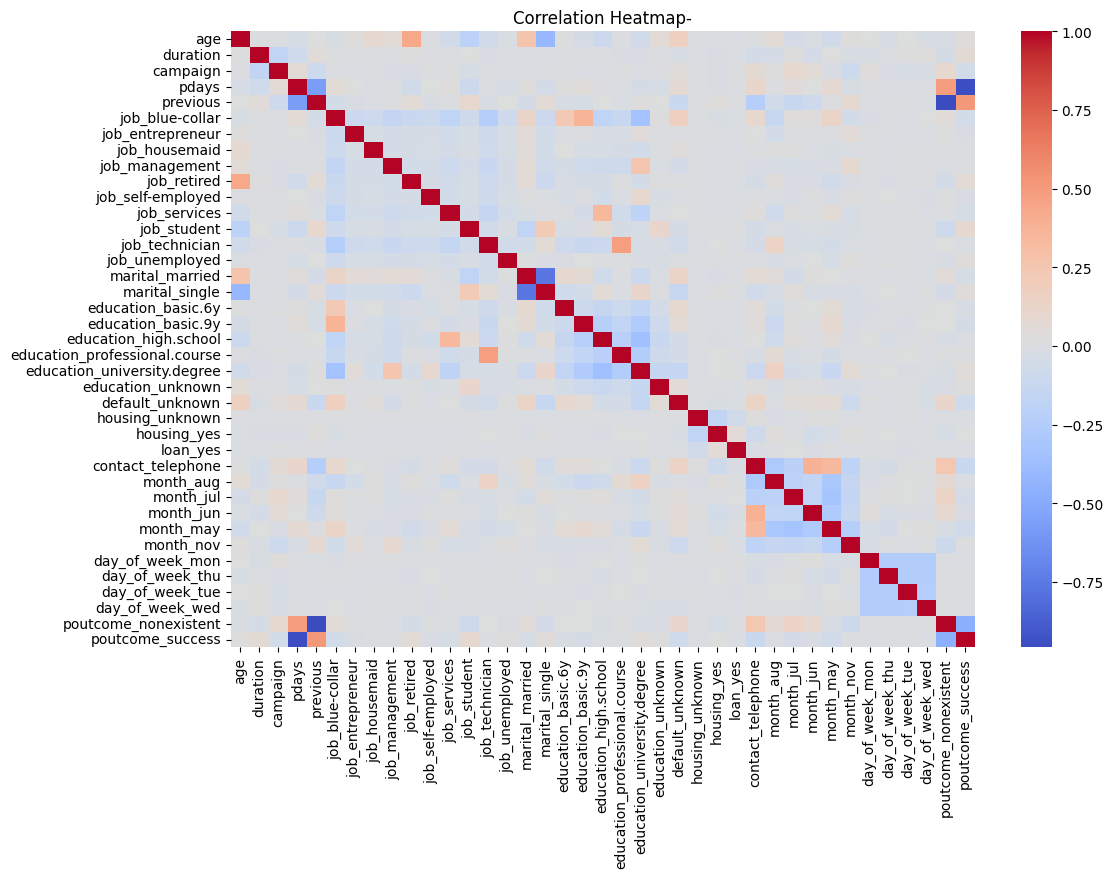

In [61]:
#Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap-")
plt.show()

**Step-8:** Mututal Information Regression

In [62]:
mi_scores = mutual_info_regression(X, y, discrete_features=False)
mi_df = pd.Series(mi_scores, index=X.columns)
mi_df = mi_df.sort_values(ascending=False)


low_importance = mi_df[mi_df < 0.01].index.tolist()

print("Mututal Information: ",low_importance)
print("\nTotal: ", len(low_importance))

X = X.drop(columns=low_importance,axis=1)


Mututal Information:  ['poutcome_nonexistent', 'education_unknown', 'job_services', 'day_of_week_mon', 'loan_yes', 'month_jun', 'job_blue-collar', 'month_may', 'job_retired', 'month_aug', 'job_entrepreneur', 'job_self-employed', 'job_management', 'job_housemaid', 'education_university.degree', 'education_professional.course', 'education_high.school', 'education_basic.9y', 'marital_married', 'education_basic.6y', 'job_technician', 'job_unemployed', 'job_student', 'month_jul', 'housing_unknown', 'housing_yes', 'day_of_week_thu', 'month_nov', 'day_of_week_wed', 'day_of_week_tue']

Total:  30


In [63]:
#Chi Square cannot be applied since the output feature is numerical

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [66]:
from sklearn.feature_selection import f_regression
import pandas as pd

# 1. Select numerical features

# 2. Compute F-statistic and p-values
f_scores, p_values = f_regression(X_train, y_train)

# 3. Wrap into a DataFrame for better understanding
anova_df = pd.DataFrame({
    'F_Score': f_scores,
    'P_Value': p_values
}, index=X_train.columns)

# 4. Sort by F-score (descending)
anova_df = anova_df.sort_values(by='F_Score', ascending=False)

# 5. Optional: remove features with weak relationship (e.g., p-value > 0.05)
insignificant_features = anova_df[anova_df['P_Value'] > 0.05].index.tolist()

print("Dropping features with weak linear relationship:", insignificant_features)
print("Total: ", len(insignificant_features))

# 6. Drop those from train and test
X_train = X_train.drop(columns=insignificant_features)
X_test = X_test.drop(columns=insignificant_features)

Dropping features with weak linear relationship: []
Total:  0


**Scaling the dataset**

In [67]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Training using the RandomForestClassifer

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5798
           1       0.54      0.38      0.44       792

    accuracy                           0.89      6590
   macro avg       0.73      0.67      0.69      6590
weighted avg       0.87      0.89      0.88      6590



**Evaluate the Model**

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8861911987860395
Precision: 0.8726695991668368
Recall: 0.8861911987860395
F1 Score: 0.877453350897964


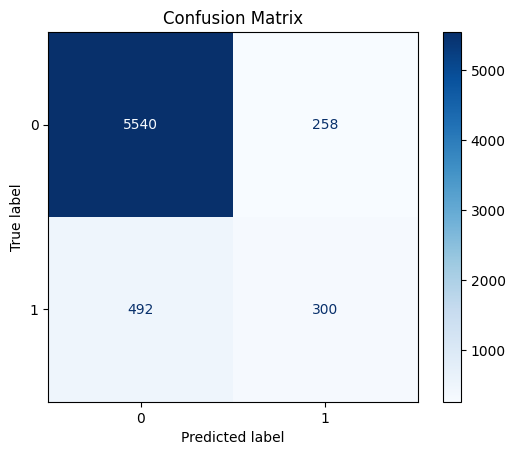

In [70]:
#confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [71]:
#Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5798
           1       0.54      0.38      0.44       792

    accuracy                           0.89      6590
   macro avg       0.73      0.67      0.69      6590
weighted avg       0.87      0.89      0.88      6590



**Feature Importance**

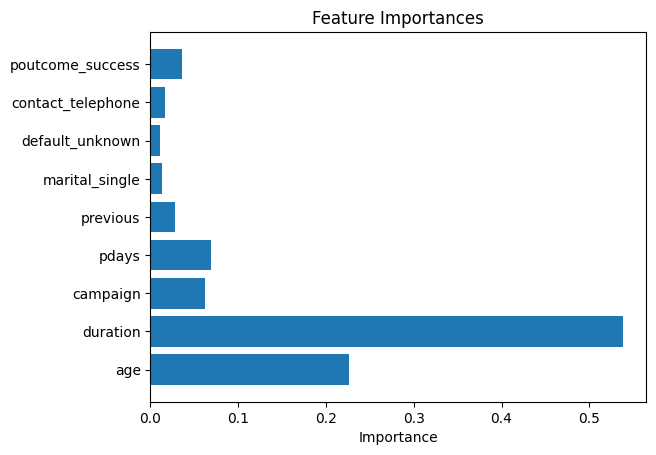

In [72]:
importances = rf.feature_importances_
features = X_train.columns
plt.barh(features, importances)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

# Training using the Logistic Regression

In [74]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=500)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

**Evaluating the Model**

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr, average='weighted')
recall = recall_score(y_test, y_pred_lr, average='weighted')
f1 = f1_score(y_test, y_pred_lr, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8980273141122913
Precision: 0.8819771436141292
Recall: 0.8980273141122913
F1 Score: 0.880510739881234


**Confusion Matrix**

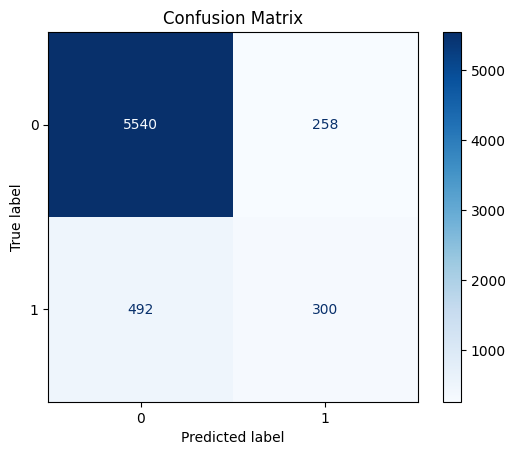

In [76]:
#confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [77]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5798
           1       0.54      0.38      0.44       792

    accuracy                           0.89      6590
   macro avg       0.73      0.67      0.69      6590
weighted avg       0.87      0.89      0.88      6590



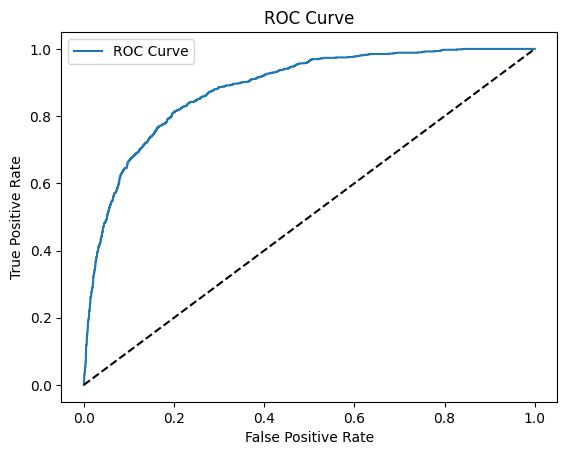

ROC AUC Score: 0.883281765568761


In [78]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_proba = lr.predict_proba(X_test_scaled)[:, 1]  # probability of class 1

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


In [79]:
from sklearn.metrics import log_loss
print("Log Loss:", log_loss(y_test, lr.predict_proba(X_test_scaled)))

Log Loss: 0.24892890957901054
